In [1]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [2]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [87]:
filename =filelist[0]
f = h5py.File(filename+".hdf5", "r")
amp = 3

stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]        #exclude zero

assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)

test_size = 0.33
svm_kernel = 'linear'
baseav = False

n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

clf = svm.SVC(kernel=svm_kernel)

means = []
stds = []
for site in range(n_dendrites):

    data = f['data']
    meta = f['meta']

    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    if baseav == True:
        baseline = np.mean(baseline, axis=0)

    mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0

    trials_mask = np.logical_or(present_mask, absent_mask)

    y_score = mn_dnd_chng[trials_mask, site]

    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2
    X_train, X_test, y_train, y_test = train_test_split(y_score, y_true, test_size=test_size)
    
    #clf.fit(X_train.reshape(X_train.shape[0], 1), y_train.reshape(y_train.shape[0], 1))
    scores = cross_val_score(clf, y_score.reshape(y_score.shape[0], 1), y_true.reshape(y_true.shape[0]), cv=5)
    mean = scores.mean()
    stdv = scores.std()
    means.append(mean)
    stds.append(stdv)
                             
    print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, mean, stdv*2))

For recording site 0: accuracy:  0.85 (+/-  0.14)
For recording site 1: accuracy:  0.80 (+/-  0.14)
For recording site 2: accuracy:  0.42 (+/-  0.10)
For recording site 3: accuracy:  0.60 (+/-  0.24)
For recording site 4: accuracy:  0.52 (+/-  0.10)
For recording site 5: accuracy:  0.45 (+/-  0.11)
For recording site 6: accuracy:  0.55 (+/-  0.14)
For recording site 7: accuracy:  0.52 (+/-  0.05)
For recording site 8: accuracy:  0.71 (+/-  0.16)
For recording site 9: accuracy:  0.48 (+/-  0.05)
For recording site 10: accuracy:  0.59 (+/-  0.12)
For recording site 11: accuracy:  0.54 (+/-  0.16)
For recording site 12: accuracy:  0.47 (+/-  0.05)
For recording site 13: accuracy:  0.56 (+/-  0.04)
For recording site 14: accuracy:  0.54 (+/-  0.12)
For recording site 15: accuracy:  0.53 (+/-  0.14)
For recording site 16: accuracy:  0.53 (+/-  0.10)
For recording site 17: accuracy:  0.62 (+/-  0.19)
For recording site 18: accuracy:  0.58 (+/-  0.14)
For recording site 19: accuracy:  0.51 (+

In [90]:
n_out = 6
inds = np.argsort(means)[::-1]

print("{} recordings sites best for classification:".format(n_out))
for i in range(n_out):
    print("At recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(inds[i], means[inds[i]], stds[inds[i]]*2))

6 recordings sites best for classification:
At recording site 109: accuracy:  0.90 (+/-  0.21)
At recording site 0: accuracy:  0.85 (+/-  0.14)
At recording site 66: accuracy:  0.83 (+/-  0.15)
At recording site 111: accuracy:  0.83 (+/-  0.19)
At recording site 114: accuracy:  0.82 (+/-  0.14)
At recording site 97: accuracy:  0.81 (+/-  0.12)


(0, 1)

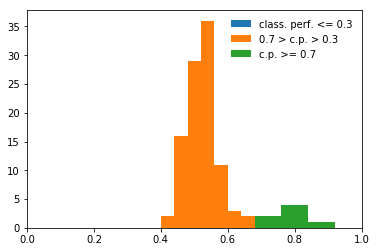

In [91]:
means = np.asarray(means)

lo_mask = means <= 0.3
mid_mask = np.logical_and(means >0.3, means < 0.7)
hi_mask = means >= 0.7

plt.hist(means[lo_mask], bins=50, range=(-1,1), label='class. perf. <= 0.3')
plt.hist(means[mid_mask], bins=50, range=(-1,1), label='0.7 > c.p. > 0.3')
plt.hist(means[hi_mask], bins=50, range=(-1,1), label='c.p. >= 0.7')
plt.legend(frameon=False)
plt.xlim(0,1)

In [115]:
filename = filelist[0]

f = h5py.File(filename+".hdf5", "r")
stims = np.unique(f['meta'][:,1])[1:]        #exclude zero
test_size = 0.33
svm_kernel = 'linear'
baseav = False

sc = []
for amp in stims:
    #average delta F
    #1s = 58 frames
    data = f['data']
    meta = f['meta']

    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    if baseav == True:
        baseline = np.mean(baseline, axis=0)

    mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0

    trials_mask = np.logical_or(present_mask, absent_mask)

    y_score = mn_dnd_chng[trials_mask, :]

    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2

    n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

    clf = svm.SVC(kernel=svm_kernel)
    scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=10)
    sc.append(scores)

In [116]:
for k, scores in enumerate(sc):
    print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f})".format(stims[k], np.mean(scores), 2*np.std(scores)))

For stimApm  0.50: accuracy:  0.46 (+/-  0.13)
For stimApm  1.00: accuracy:  0.66 (+/-  0.24)
For stimApm  1.50: accuracy:  0.68 (+/-  0.15)
For stimApm  2.00: accuracy:  0.79 (+/-  0.30)
For stimApm  2.50: accuracy:  0.83 (+/-  0.28)
For stimApm  3.00: accuracy:  0.95 (+/-  0.16)


<Container object of 3 artists>

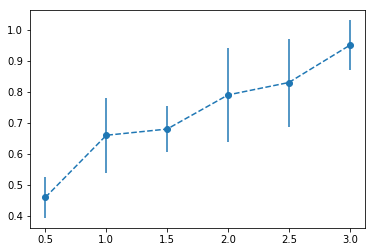

In [117]:
sc = np.array(sc)
means = np.mean(sc, axis=1)
std = np.std(sc, axis=1)

plt.errorbar(stims, means, yerr=std, fmt='--o')